# Notebook 6: Trying with last periodicity of 1,2,7

# Data

The data is downloaded from NATIONAL CENTRE FOR POLAR AND OCEAN RESEARCH, India: http://data.ncaor.gov.in/newhtml

# Dataset Info

In [1]:
with open('b_imdncpor_synoptic.txt') as f:
    print(' '.join(f.readlines()))


 ----------------------Synoptic Data-------------------------------------------------------------------
 
 Measurements/ data	: Synoptic
 Parameters		: Observation Time,  wind direction, wind speed, temparature, MSLP
 Duration		: 05-05-2016 to	02-08-2021
 Location		: Bharati
 Latitude and Longitude	: 69Â°24.41'S, 76Â°11.72'E
 Data file format	: ASCII
 
 ------------------------------------------------------------------------------------------------------
 
 
 



In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('synoptic_bharati.csv')
df.Time = pd.to_datetime(df.Time)
df.head()

,Time,WindDirection,WindSpeed,Temperature,Pressure
0,2016-05-01 00:00:00,5,8.0,-21.5,981.1
1,2016-05-22 00:00:00,0,0.0,-19.4,986.1
2,2016-05-22 06:00:00,9,10.0,-16.6,980.4
3,2016-05-22 12:00:00,9,9.0,-17.4,973.4
4,2016-05-22 18:00:00,5,13.0,-17.4,970.7


In [4]:
min_time = df.Time.min()
max_time = df.Time.max()
weather_data = pd.DataFrame(pd.date_range(min_time,max_time, freq='6H'), columns=['Time'])
weather_data.head()

,Time
0,2016-05-01 00:00:00
1,2016-05-01 06:00:00
2,2016-05-01 12:00:00
3,2016-05-01 18:00:00
4,2016-05-02 00:00:00


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [5]:
weather_data = pd.merge(weather_data, df, on='Time', how='left')
weather_data.isna().sum()

Time                0
WindDirection    1906
WindSpeed        2013
Temperature      1922
Pressure         2268
dtype: int64

In [6]:
weather_data = weather_data.loc[2715:6000] # Through manual inspection and checking

Using Temperature data to forecast future temperature.

In [7]:
temp_df = weather_data[['Temperature']].copy()
temp_df.head()

,Temperature
2715,-14.6
2716,-17.2
2717,-14.0
2718,-15.5
2719,-16.8


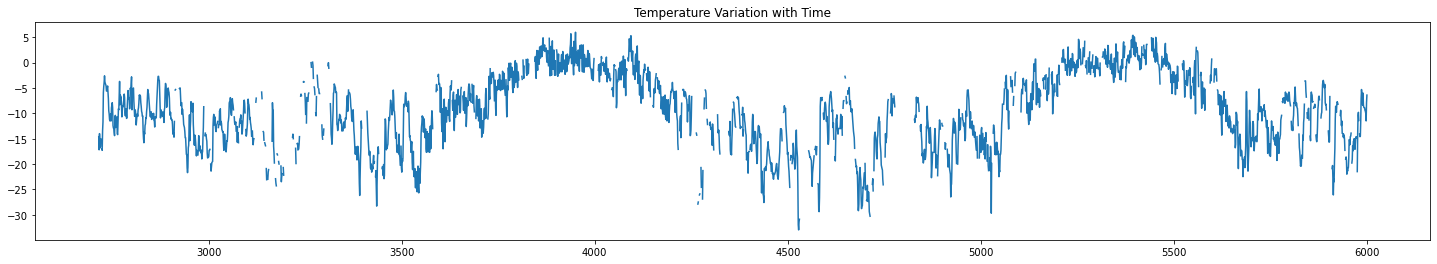

In [8]:
weather_data.Temperature.plot(figsize=(25,4), title='Temperature Variation with Time')
plt.show()

We can see highest temperature around january and lowet temperatures around July to October.

In [9]:
def simple_x_y_splitter(dataframe, col, prev_n_days=[]):
    df = dataframe.copy()
    for lag in prev_n_days:
        df[f'lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    y = df[col].values
    X = df.drop([col], axis=1).values
    return np.expand_dims(X,2), y

In [10]:
X, y = simple_x_y_splitter(temp_df, 'Temperature',prev_n_days=[1,2,7])


In [11]:
y

array([-13.4, -11.7,  -5.9, ..., -11.5,  -7.9,  -6.4])

In [12]:
X

array([[[-17.3],
        [-17. ],
        [-15.5]],

       [[-13.4],
        [-17.3],
        [-16.8]],

       [[-11.7],
        [-13.4],
        [-16.5]],

       ...,

       [[-10. ],
        [ -9.6],
        [ -8.4]],

       [[-11.5],
        [-10. ],
        [ -8.8]],

       [[ -7.9],
        [-11.5],
        [ -8.9]]])

In [13]:
y.shape

(1983,)

# Temporal splitting

In [14]:
train_val_split_idx, val_test_split_idx = int(X.shape[0]*.7), int(X.shape[0]*.85)
print(train_val_split_idx, val_test_split_idx)
X_train, y_train = X[:train_val_split_idx], y[:train_val_split_idx]
X_val, y_val = X[train_val_split_idx:val_test_split_idx], y[train_val_split_idx:val_test_split_idx]
X_test, y_test = X[val_test_split_idx:], y[val_test_split_idx:]

1388 1685


# Standardization

In [15]:
X_train_mean = X_train.mean()
X_train_sd= X_train.std()
y_train_mean = y_train.mean()
y_train_sd= y_train.std()

def standardize(x, y):
    x_std = (x-X_train_mean)/X_train_sd
    y_std = (y-y_train_mean)/y_train_sd
    return x_std, y_std

X_train_std, y_train_std = standardize(X_train, y_train)
X_val_std, y_val_std = standardize(X_val, y_val)
X_test_std, y_test_std = standardize(X_test, y_test)

# LSTM Model 1

In [16]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [17]:
from tensorflow.keras.callbacks import TensorBoard

tb1 = TensorBoard(
    log_dir='logs6',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [22]:
model1 = Sequential()
model1.add(InputLayer((3,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [23]:
cp1 = ModelCheckpoint('model6/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [24]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1, tb1])

Epoch 1/50
37/44 [========================>.....] - ETA: 0s - loss: 140.0637 - root_mean_squared_error: 11.8348

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 25s 362ms/step - loss: 133.6206 - root_mean_squared_error: 11.5594 - val_loss: 25.2290 - val_root_mean_squared_error: 5.0228
Epoch 2/50
36/44 [=======================>......] - ETA: 0s - loss: 70.5645 - root_mean_squared_error: 8.4003

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 14s 336ms/step - loss: 64.8776 - root_mean_squared_error: 8.0547 - val_loss: 14.2269 - val_root_mean_squared_error: 3.7719
Epoch 3/50
38/44 [========================>.....] - ETA: 0s - loss: 29.5234 - root_mean_squared_error: 5.4335

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 17s 385ms/step - loss: 28.1639 - root_mean_squared_error: 5.3070 - val_loss: 9.6584 - val_root_mean_squared_error: 3.1078
Epoch 4/50
37/44 [========================>.....] - ETA: 0s - loss: 17.8021 - root_mean_squared_error: 4.2193

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 18s 409ms/step - loss: 17.6690 - root_mean_squared_error: 4.2035 - val_loss: 7.8096 - val_root_mean_squared_error: 2.7946
Epoch 5/50
39/44 [=========================>....] - ETA: 0s - loss: 12.4519 - root_mean_squared_error: 3.5287

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 19s 453ms/step - loss: 12.1897 - root_mean_squared_error: 3.4914 - val_loss: 7.0521 - val_root_mean_squared_error: 2.6556
Epoch 6/50
43/44 [============================>.] - ETA: 0s - loss: 9.2564 - root_mean_squared_error: 3.0424

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 16s 377ms/step - loss: 9.2588 - root_mean_squared_error: 3.0428 - val_loss: 6.4172 - val_root_mean_squared_error: 2.5332
Epoch 7/50
43/44 [============================>.] - ETA: 0s - loss: 7.1948 - root_mean_squared_error: 2.6823

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 18s 419ms/step - loss: 7.2897 - root_mean_squared_error: 2.6999 - val_loss: 5.7815 - val_root_mean_squared_error: 2.4045
Epoch 8/50
39/44 [=========================>....] - ETA: 0s - loss: 5.9993 - root_mean_squared_error: 2.4494

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 18s 428ms/step - loss: 5.9680 - root_mean_squared_error: 2.4430 - val_loss: 5.4854 - val_root_mean_squared_error: 2.3421
Epoch 9/50
44/44 [==============================] - 0s 9ms/step - loss: 5.2576 - root_mean_squared_error: 2.2929 - val_loss: 5.4958 - val_root_mean_squared_error: 2.3443
Epoch 10/50
44/44 [==============================] - 0s 9ms/step - loss: 4.8102 - root_mean_squared_error: 2.1932 - val_loss: 5.6723 - val_root_mean_squared_error: 2.3817
Epoch 11/50
39/44 [=========================>....] - ETA: 0s - loss: 4.5558 - root_mean_squared_error: 2.1344

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 25s 574ms/step - loss: 4.5261 - root_mean_squared_error: 2.1275 - val_loss: 5.3594 - val_root_mean_squared_error: 2.3150
Epoch 12/50
44/44 [==============================] - 0s 9ms/step - loss: 4.5081 - root_mean_squared_error: 2.1232 - val_loss: 5.3956 - val_root_mean_squared_error: 2.3228
Epoch 13/50
44/44 [==============================] - 0s 10ms/step - loss: 4.5423 - root_mean_squared_error: 2.1313 - val_loss: 5.4402 - val_root_mean_squared_error: 2.3324
Epoch 14/50
42/44 [===========================>..] - ETA: 0s - loss: 4.2014 - root_mean_squared_error: 2.0497

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 17s 400ms/step - loss: 4.2681 - root_mean_squared_error: 2.0659 - val_loss: 5.3134 - val_root_mean_squared_error: 2.3051
Epoch 15/50
44/44 [==============================] - 1s 16ms/step - loss: 4.1637 - root_mean_squared_error: 2.0405 - val_loss: 5.3225 - val_root_mean_squared_error: 2.3071
Epoch 16/50
44/44 [==============================] - 2s 37ms/step - loss: 4.1623 - root_mean_squared_error: 2.0402 - val_loss: 5.4009 - val_root_mean_squared_error: 2.3240
Epoch 17/50
36/44 [=======================>......] - ETA: 0s - loss: 4.0050 - root_mean_squared_error: 2.0012

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 22s 509ms/step - loss: 4.0714 - root_mean_squared_error: 2.0178 - val_loss: 5.2826 - val_root_mean_squared_error: 2.2984
Epoch 18/50
39/44 [=========================>....] - ETA: 0s - loss: 4.1494 - root_mean_squared_error: 2.0370

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 18s 416ms/step - loss: 4.1825 - root_mean_squared_error: 2.0451 - val_loss: 5.2612 - val_root_mean_squared_error: 2.2937
Epoch 19/50
44/44 [==============================] - 0s 11ms/step - loss: 3.9201 - root_mean_squared_error: 1.9799 - val_loss: 5.2875 - val_root_mean_squared_error: 2.2995
Epoch 20/50
41/44 [==========================>...] - ETA: 0s - loss: 4.0512 - root_mean_squared_error: 2.0128

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 17s 388ms/step - loss: 4.0217 - root_mean_squared_error: 2.0054 - val_loss: 5.2122 - val_root_mean_squared_error: 2.2830
Epoch 21/50
44/44 [==============================] - 0s 9ms/step - loss: 3.9555 - root_mean_squared_error: 1.9889 - val_loss: 5.2609 - val_root_mean_squared_error: 2.2937
Epoch 22/50
44/44 [==============================] - ETA: 0s - loss: 3.9247 - root_mean_squared_error: 1.9811

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 20s 455ms/step - loss: 3.9247 - root_mean_squared_error: 1.9811 - val_loss: 5.1596 - val_root_mean_squared_error: 2.2715
Epoch 23/50
43/44 [============================>.] - ETA: 0s - loss: 3.9044 - root_mean_squared_error: 1.9760

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 24s 555ms/step - loss: 3.9560 - root_mean_squared_error: 1.9890 - val_loss: 5.1548 - val_root_mean_squared_error: 2.2704
Epoch 24/50
44/44 [==============================] - 0s 8ms/step - loss: 4.0431 - root_mean_squared_error: 2.0107 - val_loss: 5.1798 - val_root_mean_squared_error: 2.2759
Epoch 25/50
44/44 [==============================] - 0s 9ms/step - loss: 3.9190 - root_mean_squared_error: 1.9796 - val_loss: 5.1790 - val_root_mean_squared_error: 2.2757
Epoch 26/50
40/44 [==========================>...] - ETA: 0s - loss: 3.9057 - root_mean_squared_error: 1.9763

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 14s 322ms/step - loss: 3.9210 - root_mean_squared_error: 1.9802 - val_loss: 5.1099 - val_root_mean_squared_error: 2.2605
Epoch 27/50
44/44 [==============================] - 0s 9ms/step - loss: 3.9112 - root_mean_squared_error: 1.9777 - val_loss: 5.1375 - val_root_mean_squared_error: 2.2666
Epoch 28/50
44/44 [==============================] - ETA: 0s - loss: 4.1142 - root_mean_squared_error: 2.0283

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 21s 497ms/step - loss: 4.1142 - root_mean_squared_error: 2.0283 - val_loss: 5.1017 - val_root_mean_squared_error: 2.2587
Epoch 29/50
41/44 [==========================>...] - ETA: 0s - loss: 3.7889 - root_mean_squared_error: 1.9465

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 20s 471ms/step - loss: 3.8727 - root_mean_squared_error: 1.9679 - val_loss: 5.0641 - val_root_mean_squared_error: 2.2504
Epoch 30/50
44/44 [==============================] - 0s 9ms/step - loss: 3.9144 - root_mean_squared_error: 1.9785 - val_loss: 5.0833 - val_root_mean_squared_error: 2.2546
Epoch 31/50
44/44 [==============================] - ETA: 0s - loss: 4.1261 - root_mean_squared_error: 2.0313

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 20s 475ms/step - loss: 4.1261 - root_mean_squared_error: 2.0313 - val_loss: 5.0523 - val_root_mean_squared_error: 2.2477
Epoch 32/50
44/44 [==============================] - 1s 15ms/step - loss: 3.8156 - root_mean_squared_error: 1.9534 - val_loss: 5.0959 - val_root_mean_squared_error: 2.2574
Epoch 33/50
44/44 [==============================] - 0s 9ms/step - loss: 3.9221 - root_mean_squared_error: 1.9804 - val_loss: 5.0600 - val_root_mean_squared_error: 2.2494
Epoch 34/50
44/44 [==============================] - 1s 21ms/step - loss: 3.8065 - root_mean_squared_error: 1.9510 - val_loss: 5.0571 - val_root_mean_squared_error: 2.2488
Epoch 35/50
44/44 [==============================] - ETA: 0s - loss: 3.9751 - root_mean_squared_error: 1.9938

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 19s 435ms/step - loss: 3.9751 - root_mean_squared_error: 1.9938 - val_loss: 5.0263 - val_root_mean_squared_error: 2.2419
Epoch 36/50
36/44 [=======================>......] - ETA: 0s - loss: 4.0235 - root_mean_squared_error: 2.0059

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 14s 314ms/step - loss: 3.9711 - root_mean_squared_error: 1.9928 - val_loss: 4.9859 - val_root_mean_squared_error: 2.2329
Epoch 37/50
44/44 [==============================] - 0s 8ms/step - loss: 3.8487 - root_mean_squared_error: 1.9618 - val_loss: 5.1118 - val_root_mean_squared_error: 2.2609
Epoch 38/50
44/44 [==============================] - 0s 8ms/step - loss: 3.8977 - root_mean_squared_error: 1.9743 - val_loss: 5.0071 - val_root_mean_squared_error: 2.2376
Epoch 39/50
44/44 [==============================] - 0s 10ms/step - loss: 3.8058 - root_mean_squared_error: 1.9508 - val_loss: 4.9923 - val_root_mean_squared_error: 2.2343
Epoch 40/50
44/44 [==============================] - 0s 9ms/step - loss: 3.8564 - root_mean_squared_error: 1.9638 - val_loss: 4.9925 - val_root_mean_squared_error: 2.2344
Epoch 41/50
44/44 [==============================] - 0s 8ms/step - loss: 3.8132 - root_mean_squared_error: 1.9528 - val_loss: 5.0037 - val_root_mean_squa

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 13s 306ms/step - loss: 3.8812 - root_mean_squared_error: 1.9701 - val_loss: 4.9854 - val_root_mean_squared_error: 2.2328
Epoch 43/50
44/44 [==============================] - 0s 8ms/step - loss: 3.8113 - root_mean_squared_error: 1.9523 - val_loss: 5.0354 - val_root_mean_squared_error: 2.2440
Epoch 44/50
44/44 [==============================] - 0s 11ms/step - loss: 3.7545 - root_mean_squared_error: 1.9376 - val_loss: 4.9884 - val_root_mean_squared_error: 2.2335
Epoch 45/50
44/44 [==============================] - 1s 12ms/step - loss: 3.7601 - root_mean_squared_error: 1.9391 - val_loss: 5.0123 - val_root_mean_squared_error: 2.2388
Epoch 46/50
38/44 [========================>.....] - ETA: 0s - loss: 3.8956 - root_mean_squared_error: 1.9737

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 14s 325ms/step - loss: 3.8945 - root_mean_squared_error: 1.9735 - val_loss: 4.9760 - val_root_mean_squared_error: 2.2307
Epoch 47/50
43/44 [============================>.] - ETA: 0s - loss: 3.8160 - root_mean_squared_error: 1.9534

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 15s 349ms/step - loss: 3.8025 - root_mean_squared_error: 1.9500 - val_loss: 4.9577 - val_root_mean_squared_error: 2.2266
Epoch 48/50
44/44 [==============================] - ETA: 0s - loss: 3.8028 - root_mean_squared_error: 1.9501

INFO:tensorflow:Assets written to: model6\assets


INFO:tensorflow:Assets written to: model6\assets


44/44 [==============================] - 17s 404ms/step - loss: 3.8028 - root_mean_squared_error: 1.9501 - val_loss: 4.9567 - val_root_mean_squared_error: 2.2264
Epoch 49/50
44/44 [==============================] - 0s 8ms/step - loss: 3.8848 - root_mean_squared_error: 1.9710 - val_loss: 5.0454 - val_root_mean_squared_error: 2.2462
Epoch 50/50
44/44 [==============================] - 1s 21ms/step - loss: 3.9310 - root_mean_squared_error: 1.9827 - val_loss: 5.0152 - val_root_mean_squared_error: 2.2395


In [25]:
def post_process(y):
    return (X_train_sd*y)+X_train_mean

In [26]:
from tensorflow.keras.models import load_model
model1 = load_model('model6/')

In [27]:
predicted_test_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_test_std).flatten()), 'Actual Temperature': y_test})
predicted_val_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_val_std).flatten()), 'Actual Temperature': y_val})
predicted_train_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_train_std).flatten()), 'Actual Temperature': y_train})

44/44 [==============================] - 0s 4ms/step


In [28]:
from sklearn.metrics import mean_squared_error

<AxesSubplot:title={'center':'RMSE: 2.8316571367876766'}>

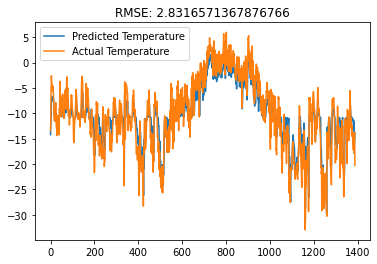

In [29]:
predicted_train_df.plot(title=f"RMSE: {mean_squared_error(predicted_train_df['Actual Temperature'], predicted_train_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:2.86485764490078'}>

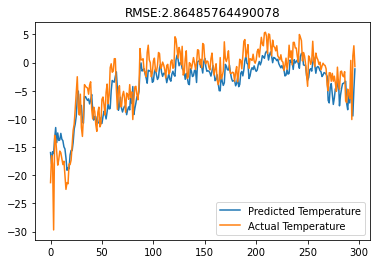

In [30]:
predicted_val_df.plot(title = f"RMSE:{mean_squared_error(predicted_val_df['Actual Temperature'], predicted_val_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:2.87180190054605'}>

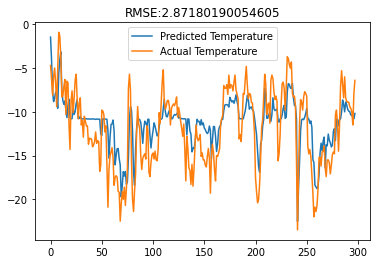

In [31]:
predicted_test_df.plot(title = f"RMSE:{mean_squared_error(predicted_test_df['Actual Temperature'], predicted_test_df['Predicted Temperature'], squared=False)}")


In [ ]:
y.shape

(1764,)